In [9]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,  StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from joblib import Parallel, delayed

# Preprocessing 

##### Data exploration : getting info from the data, dropping unusefull features

In [10]:
# Data reading
data = pd.read_csv('Data/Water Quality Prediction.csv')

# Data info
print("Informations sur les données :")
data.info()
print("\nNombre de valeurs uniques par colonne :")
print(data.nunique())
# Distribution des classes cibles
print("\nRépartition des classes cibles :\n", data['Target'].value_counts())

# Unusefull feature dropping
features_to_drop = ['Index','Month','Day','Time of Day']
data.drop(columns=features_to_drop, inplace=True)

data.head()

Informations sur les données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 24 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Index                   1048575 non-null  int64  
 1   pH                      1028344 non-null  float64
 2   Iron                    1041584 non-null  float64
 3   Nitrate                 1029880 non-null  float64
 4   Chloride                1017741 non-null  float64
 5   Lead                    1043891 non-null  float64
 6   Zinc                    1020900 non-null  float64
 7   Color                   1047594 non-null  object 
 8   Turbidity               1039881 non-null  float64
 9   Fluoride                1015357 non-null  float64
 10  Copper                  1013693 non-null  float64
 11  Odor                    1017243 non-null  float64
 12  Sulfate                 1014050 non-null  float64
 13  Conductivity            10

,pH,Iron,Nitrate,Chloride,Lead,Zinc,Color,Turbidity,Fluoride,Copper,Odor,Sulfate,Conductivity,Chlorine,Manganese,Total Dissolved Solids,Source,Water Temperature,Air Temperature,Target
0,8.332988,0.000083,8.605777,122.799772,3.710000e-52,3.434827,Colorless,0.022683,0.607283,0.144599,1.626212,87.266538,471.683357,3.708178,2.270000e-15,332.118789,NaN,NaN,43.493324,0
1,6.917863,0.000081,3.734167,227.029851,7.850000e-94,1.245317,Faint Yellow,0.019007,0.622874,0.437835,1.686049,144.010981,432.844908,3.292038,8.020000e-07,284.641984,Lake,15.348981,71.220586,0
2,5.443762,0.020106,3.816994,230.995630,5.290000e-76,0.528280,Light Yellow,0.319956,0.423423,0.431588,3.414619,275.702107,990.201209,3.560224,7.007989e-02,570.054094,River,11.643467,44.891330,0
3,7.955339,0.143988,8.224944,178.129940,4.000000e-176,4.027879,Near Colorless,0.166319,0.208454,0.239451,NaN,147.163233,237.028468,3.516907,2.468295e-02,100.043838,Ground,10.092392,60.843233,0
4,8.091909,0.002167,9.925788,186.540872,4.170000e-132,3.807511,Light Yellow,0.004867,0.222912,0.616574,0.795310,175.275175,385.025855,3.177849,3.296139e-03,168.075545,Spring,15.249416,69.336671,0


#### NaN values location visualization 

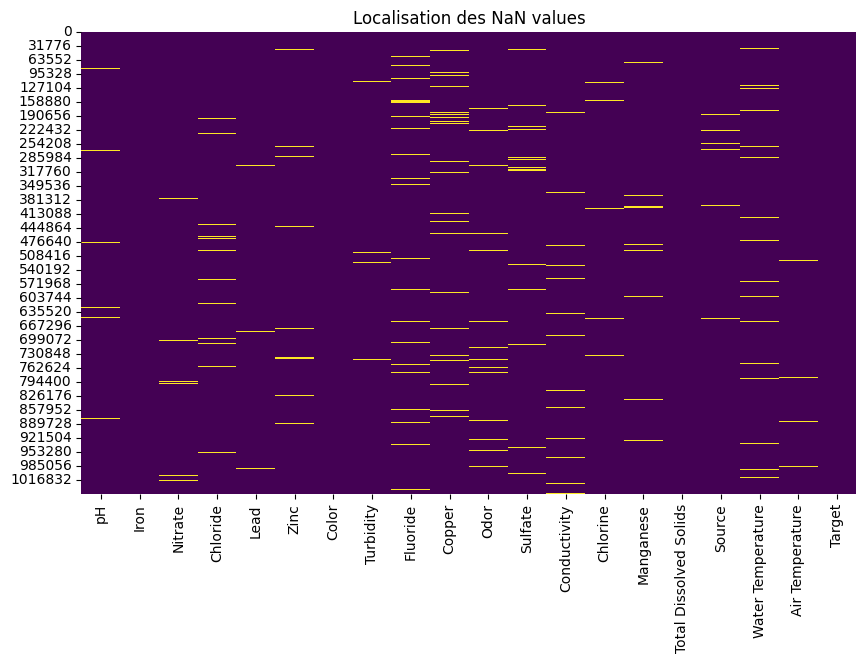

In [3]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.isna(), cbar=False, cmap="viridis")
plt.title("Localisation des NaN values")
plt.show()

#### NaN values 

In [12]:
# Calcul du pourcentage de NaN
nan_percentage = data.isna().mean() * 100
print("\nPourcentage de valeurs manquantes avant traitement :\n", nan_percentage)

# Suppression des colonnes avec plus de 50% de NaN
data.drop(columns=nan_percentage[nan_percentage > 50].index, inplace=True)

# Identification des colonnes numériques et catégorielles
num_cols = data.select_dtypes(include=['float64', 'int64']).columns
cat_cols = data.select_dtypes(include=['object']).columns

# Imputation des valeurs manquantes
num_imputer = SimpleImputer(strategy='mean')  # Imputation par la moyenne
cat_imputer = SimpleImputer(strategy='most_frequent')  # Mode pour les catégorielles

data[num_cols] = num_imputer.fit_transform(data[num_cols])
data[cat_cols] = cat_imputer.fit_transform(data[cat_cols])

# Vérification des NaN après imputation
print("\nValeurs manquantes après traitement :\n", data.isna().sum())


Pourcentage de valeurs manquantes avant traitement :
 pH                        0.0
Iron                      0.0
Nitrate                   0.0
Chloride                  0.0
Lead                      0.0
Zinc                      0.0
Color                     0.0
Turbidity                 0.0
Fluoride                  0.0
Copper                    0.0
Odor                      0.0
Sulfate                   0.0
Conductivity              0.0
Chlorine                  0.0
Manganese                 0.0
Total Dissolved Solids    0.0
Source                    0.0
Water Temperature         0.0
Air Temperature           0.0
Target                    0.0
dtype: float64

Valeurs manquantes après traitement :
 pH                        0
Iron                      0
Nitrate                   0
Chloride                  0
Lead                      0
Zinc                      0
Color                     0
Turbidity                 0
Fluoride                  0
Copper                    0
Odor      

In [13]:
# Encodage des colonnes catégorielles
df_cat = data.select_dtypes(include=['object']).copy()
cat_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
df_cat_encoded = cat_encoder.fit_transform(df_cat)
df_cat_encoded = pd.DataFrame(df_cat_encoded, columns=cat_encoder.get_feature_names_out(df_cat.columns))

df_cat_encoded.index = data.index
data = pd.concat([data.drop(cat_cols, axis=1), df_cat_encoded], axis=1)

# Mettre à jour cat_cols pour refléter les nouvelles colonnes encodées
cat_cols_encoded = df_cat_encoded.columns

# Visualisation des colonnes catégorielles avant et après encodage
print("\nColonnes catégorielles avant encodage :\n", df_cat.head())
print("\nColonnes catégorielles après encodage :\n", df_cat_encoded.head())

# Statistiques descriptives
print("\nStatistiques descriptives des données numériques :\n", data.describe())

# Utiliser les nouvelles colonnes catégorielles encodées
print("\nNombre de catégories par variable catégorielle :\n", data[cat_cols_encoded].nunique())



Colonnes catégorielles avant encodage :
             Color  Source
0       Colorless    Well
1    Faint Yellow    Lake
2    Light Yellow   River
3  Near Colorless  Ground
4    Light Yellow  Spring

Colonnes catégorielles après encodage :
    Color_Colorless  Color_Faint Yellow  Color_Light Yellow  \
0              1.0                 0.0                 0.0   
1              0.0                 1.0                 0.0   
2              0.0                 0.0                 1.0   
3              0.0                 0.0                 0.0   
4              0.0                 0.0                 1.0   

   Color_Near Colorless  Color_Yellow  Source_Aquifer  Source_Ground  \
0                   0.0           0.0             0.0            0.0   
1                   0.0           0.0             0.0            0.0   
2                   0.0           0.0             0.0            0.0   
3                   1.0           0.0             0.0            1.0   
4                   0.0    

#### Rate of potable and non potable water in our dataset


Répartition de la variable cible :
Target
0.0    807841
1.0    240734
Name: count, dtype: int64


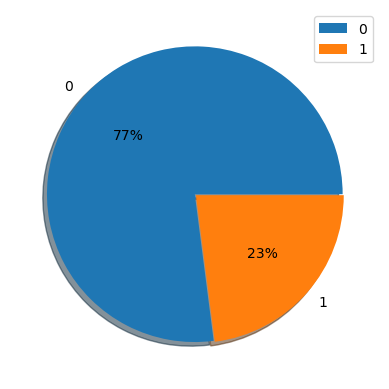

In [14]:
# Visualisation de la distribution de la variable cible
tar = data['Target'].value_counts()
print("\nRépartition de la variable cible :")
print(tar)

plt.pie(tar, labels=[0, 1], explode=[0, 0.01], autopct='%.f%%', shadow=True)
plt.legend()
plt.show()

# Training 

PCA

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Meilleur nombre de composantes PCA : 27

Variance cumulée avec 27 composantes : 100.00%


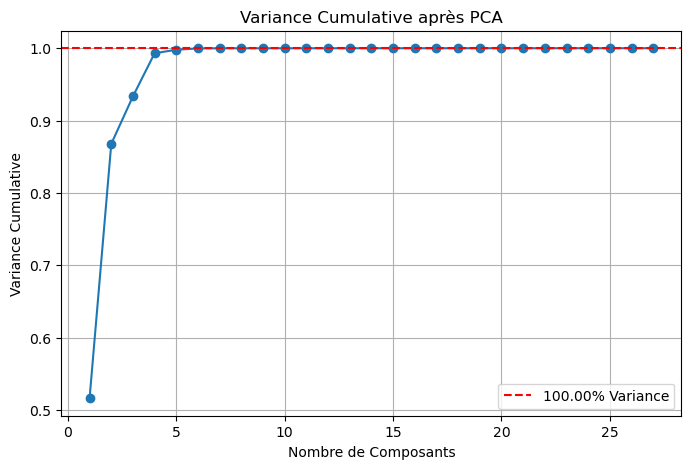

In [ ]:
# Séparation des données
X_features = data.drop('Target', axis=1)
y_target = data['Target']

# Échantillonnage aléatoire (10% des données pour accélérer)
sample_frac = 0.5
X_sampled = X_features.sample(frac=sample_frac, random_state=42)
y_sampled = y_target.loc[X_sampled.index]

# Pipeline avec PCA et un modèle rapide (LogisticRegression)
pipeline = Pipeline([
    ('pca', PCA()),
    ('clf', GaussianNB())  # Logistic Regression rapide
])

# Grille de paramètres pour PCA (seulement des fractions de composantes)
n_features = X_sampled.shape[1]
param_grid = {
    'pca__n_components': [int(n_features * x) for x in np.linspace(0.1, 1.0, 10)]  # Tester 10 valeurs
}

# Configuration de la validation croisée rapide
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=42)  # 3 splits rapides

# Configuration de la recherche par grille
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='accuracy',
    cv=cv,
    verbose=1,
    n_jobs=-1  # Utilisation parallèle
)

# Ajustement du modèle avec les données échantillonnées
grid_search.fit(X_sampled, y_sampled)

# Meilleur nombre de composantes PCA
best_n_components = grid_search.best_params_['pca__n_components']
print(f"Meilleur nombre de composantes PCA : {best_n_components}")

# Variance expliquée par les composantes sélectionnées
pca = PCA(n_components=best_n_components)
X_pca_full = pca.fit_transform(X_features)

explained_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"\nVariance cumulée avec {best_n_components} composantes : {explained_variance[-1]:.2%}")

# Visualisation de la variance cumulée
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.axhline(y=explained_variance[-1], color='r', linestyle='--', label=f"{explained_variance[-1]:.2%} Variance")
plt.title("Variance Cumulative après PCA")
plt.xlabel("Nombre de Composants")
plt.ylabel("Variance Cumulative")
plt.legend()
plt.grid()
plt.show()





Entraînement du modèle : Logistic Regression


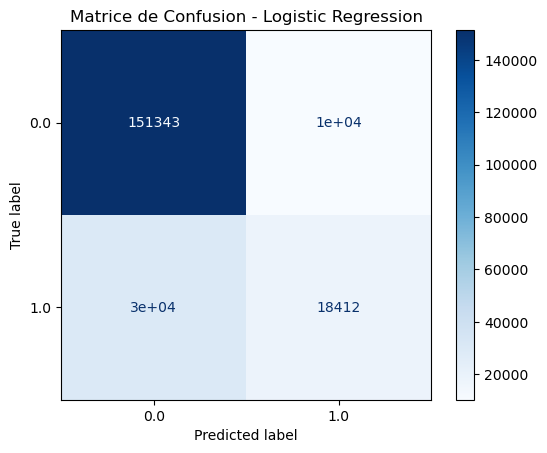

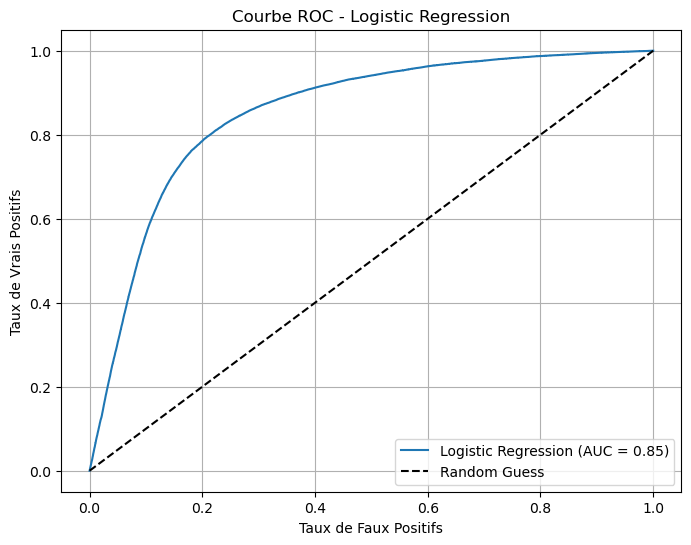


Entraînement du modèle : Decision Tree


In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Séparation des données (X et y)
X_features = data.drop('Target', axis=1)
y_target = data['Target']

# Diviser en train et test (éventuellement avec un échantillonnage)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=42)

# Liste des modèles à tester
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear'),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'Naive Bayes': GaussianNB()
}

# Fonction d'entraînement et d'évaluation avec PCA dans la pipeline
def train_and_evaluate(model_name, model, n_components):
    print(f"\nEntraînement du modèle : {model_name}")
    
    # Créer une copie des données pour éviter les problèmes de mémoire partagée
    X_train_copy = np.array(X_train)  # Convertir explicitement en ndarray
    X_test_copy = np.array(X_test)    # Convertir explicitement en ndarray
    
    # Création d'une pipeline avec PCA et le modèle
    pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),  # Mise à l'échelle des données
        ('pca', PCA(n_components=n_components)),  # PCA pour la réduction de dimension
        ('model', model)  # Modèle de classification
    ])
    
    # Entraînement du modèle
    pipeline.fit(X_train_copy, y_train)
    
    # Prédictions
    y_pred = pipeline.predict(X_test_copy)
    y_prob = pipeline.predict_proba(X_test_copy)[:, 1] if hasattr(pipeline, "predict_proba") else None
    
    # Calcul des scores
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    cv_scores = cross_val_score(pipeline, X_train_copy, y_train, cv=5, scoring='accuracy', n_jobs=1).mean()
    
    # Affichage de la matrice de confusion
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
    plt.title(f'Matrice de Confusion - {model_name}')
    plt.show()

    # Courbe ROC
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc_score(y_test, y_prob):.2f})")
        plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
        plt.title(f"Courbe ROC - {model_name}")
        plt.xlabel("Taux de Faux Positifs")
        plt.ylabel("Taux de Vrais Positifs")
        plt.legend(loc="lower right")
        plt.grid()
        plt.show()
    
    return {
        'Accuracy': accuracy,
        'AUC': auc_score,
        'F1 Score': f1,
        'CV Accuracy': cv_scores
    }

# Choisir le nombre de composantes principales pour PCA
n_components = 27  # Par exemple, pour utiliser 27 composantes principales

# Entraînement parallèle des modèles avec PCA dans la pipeline
results = Parallel(n_jobs=1)(delayed(train_and_evaluate)(name, model, n_components) for name, model in models.items())

# Résultats
results_df = pd.DataFrame(results, index=models.keys())
print("\nComparaison des modèles :\n", results_df)


In [19]:
from sklearn.decomposition import PCA
import pandas as pd

# Appliquer la PCA avec n_components = 27
n_components = 27
pca = PCA(n_components=n_components)

# Transformation des données
X_pca = pca.fit_transform(X_features)

# Convertir les résultats PCA en DataFrame
X_pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(n_components)])

# Affichage des 5 premières lignes des données transformées
print("\nLes 5 premières lignes des données après PCA :")
print(X_pca_df.head())




Les 5 premières lignes des données après PCA :
          PC1         PC2         PC3        PC4        PC5       PC6  \
0   46.904803   65.633330  -82.639335 -12.903651  16.515992  0.035439   
1    8.009729   20.628516   26.425301  36.191890 -11.174531 -3.821615   
2  565.543189  307.129163  128.334067 -42.289228  15.036983 -7.534612   
3 -187.913047 -164.626764    2.927956  -3.321831  -0.757116 -9.058165   
4  -39.876853  -96.250153   29.126747 -14.093088  -9.286815 -3.922235   

        PC7       PC8       PC9      PC10  ...      PC18      PC19      PC20  \
0  2.780932  1.891981 -0.306415 -0.733606  ...  0.013871  0.922135  0.048825   
1 -2.505355 -0.297500 -0.163835 -0.295410  ... -0.074167 -0.134926  0.302202   
2 -2.791513 -1.047383  1.482018 -0.080232  ...  0.030469 -0.162214 -0.907054   
3  2.249044  2.459615 -0.241497 -0.713986  ... -0.046930 -0.149899  0.109610   
4  3.822766  2.163148 -1.265546 -0.731216  ...  0.001851 -0.161400 -0.982868   

       PC21      PC22      PC23 

In [ ]:
pca = decomposition.PCA()
NB = GaussianNB()
Scorings = "f1_weighted"

In [13]:
# --- Validation Croisée (Cross-Validation) --- 

# Création d'un modèle de classification
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Validation croisée : utilisation de 5 plis 
cv_scores = cross_val_score(clf, X_selected, y_target, cv=5)  # cv=5 : 5 plis

# Affichage des résultats de la validation croisée
print("\nScores de validation croisée (5 plis) :", cv_scores)
print("Score moyen de la validation croisée :", np.mean(cv_scores))

KeyboardInterrupt: 

In [10]:
# Prétraitement pour modèles
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_target, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, num_cols),
        ('cat', 'passthrough', df_cat_encoded.columns)
    ]
)

### Train different models

In [11]:
# Liste des modèles
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear'),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'Naive Bayes': GaussianNB()
}

In [ ]:
# Liste des modèles
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear'),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'Naive Bayes': GaussianNB()
}

# Entraînement parallèle des modèles
def train_and_evaluate(model_name, model):
    print(f"\nEntraînement du modèle : {model_name}")
    
    # Si X_train et X_test sont des objets memmap, les convertir en DataFrame
    if isinstance(X_train, np.memmap):
        X_train_df = pd.DataFrame(X_train, columns=selected_features)
    else:
        X_train_df = pd.DataFrame(X_train, columns=selected_features)

    if isinstance(X_test, np.memmap):
        X_test_df = pd.DataFrame(X_test, columns=selected_features)
    else:
        X_test_df = pd.DataFrame(X_test, columns=selected_features)
    
    # Vérification de la présence des colonnes dans X_train et X_test
    print("Colonnes de X_train:", X_train_df.columns)
    print("Colonnes de X_test:", X_test_df.columns)
    
    # Vérifiez si 'Iron' est dans selected_features
    if 'Iron' not in selected_features:
        print("La colonne 'Iron' n'est pas dans selected_features.")
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Entraînement et prédiction
    pipeline.fit(X_train_df, y_train)  # Utilisez X_train_df et X_test_df
    y_pred = pipeline.predict(X_test_df)
    y_prob = pipeline.predict_proba(X_test_df)[:, 1] if hasattr(pipeline, "predict_proba") else None
    
    # Évaluation
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    cv_scores = cross_val_score(pipeline, X_train_df, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
    
    # Matrice de confusion
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
    plt.title(f'Matrice de Confusion - {model_name}')
    plt.show()

    # Courbe ROC
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc_score(y_test, y_prob):.2f})")
        plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
        plt.title(f"Courbe ROC - {model_name}")
        plt.xlabel("Taux de Faux Positifs")
        plt.ylabel("Taux de Vrais Positifs")
        plt.legend(loc="lower right")
        plt.grid()
        plt.show()
    
    return {
        'Accuracy': accuracy,
        'AUC': auc_score,
        'F1 Score': f1,
        'CV Accuracy': cv_scores
    }

# Entraînement parallèle des modèles
results = Parallel(n_jobs=-1)(delayed(train_and_evaluate)(name, model) for name, model in models.items())

# Résultats
results_df = pd.DataFrame(results, index=models.keys())
print("\nComparaison des modèles :\n", results_df)


Entraînement du modèle : Naive Bayes
Colonnes de X_train: Index(['pH', 'Nitrate', 'Chloride', 'Turbidity', 'Copper', 'Odor', 'Chlorine',
       'Manganese', 'Color_Colorless', 'Color_Near Colorless'],
      dtype='object')
Colonnes de X_test: Index(['pH', 'Nitrate', 'Chloride', 'Turbidity', 'Copper', 'Odor', 'Chlorine',
       'Manganese', 'Color_Colorless', 'Color_Near Colorless'],
      dtype='object')
La colonne 'Iron' n'est pas dans selected_features.

Entraînement du modèle : Logistic Regression
Colonnes de X_train: Index(['pH', 'Nitrate', 'Chloride', 'Turbidity', 'Copper', 'Odor', 'Chlorine',
       'Manganese', 'Color_Colorless', 'Color_Near Colorless'],
      dtype='object')
Colonnes de X_test: Index(['pH', 'Nitrate', 'Chloride', 'Turbidity', 'Copper', 'Odor', 'Chlorine',
       'Manganese', 'Color_Colorless', 'Color_Near Colorless'],
      dtype='object')
La colonne 'Iron' n'est pas dans selected_features.

Entraînement du modèle : Decision Tree


ValueError: A given column is not a column of the dataframe

In [ ]:
# Optimisation des hyperparamètres avec GridSearchCV
param_grids = {
    'Random Forest': {'model__n_estimators': [100, 200], 'model__max_depth': [10, 20]},
    'SVM': {'model__C': [0.1, 1, 10], 'model__kernel': ['linear', 'rbf']}
}

def perform_grid_search(model_name, model, param_grid):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Visualisation de la performance de GridSearch
    results = pd.DataFrame(grid_search.cv_results_)
    plt.figure(figsize=(8, 5))
    plt.plot(results['param_model__C'], results['mean_test_score'], label='Test Score')
    plt.plot(results['param_model__C'], results['mean_train_score'], label='Train Score')
    plt.title(f"Optimisation des hyperparamètres pour {model_name}")
    plt.xlabel("Paramètre")
    plt.ylabel("Score")
    plt.legend()
    plt.show()
    
    return model_name, grid_search.best_params_

optimized_results = Parallel(n_jobs=-1)(
    delayed(perform_grid_search)(model_name, models[model_name], param_grids[model_name])
    for model_name in param_grids.keys()
)

# Conversion des résultats en dictionnaire
optimized_results = dict(optimized_results)
print("\nMeilleurs hyperparamètres :\n", optimized_results)